In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
from astropy.io import fits

In [ ]:
#PARAMETERS - all distance measurements are in mm, all angles are in radians

#Telescope
D_T=500 #diameter
F_T=6.8 #focal ratio
FOV_X=((.175*(np.pi/180))*.25); FOV_Y=((.233*(np.pi/180))*.33) #effective field of view 
R=1000 #resolving power

#DMD
p_M=.0137 #mirror pitch
NM_X=750; NM_Y=1000 #number of mirrors in x and y dimensions
N_m1=2 #mirrors per slit in each dimension

#Grating
G=600 #grooves/mm

#Detector
p_D=.0065 #pixel pitch
ND_X=2000; ND_Y=2000
S_D=.82 #plate scale of Detector

#wavelengths
λ_c=.00055 #central
λ_max=.0007 #maximum
λ_min=.0004 #minimum

#focal lengths
f_col=85
f_cam=40

In [8]:
def get_star_list(img, threshold):
    """Return a list of the approximate positions of stars in img that exceed threshold brightness.
    """
    STAR_SIZE=10 #select an estimated average star diameter in pixels
    star_list = []

    # Look through entire image except within STAR_SIZE of the edges
    for i in range(STAR_SIZE, len(img) - STAR_SIZE):
        for j in range(STAR_SIZE, len(img[0]) - STAR_SIZE):
        
            if img[i][j] > threshold:
            
                # Potential star candidate!
                new_star = True
                
                # First test: check one pixel above, below, left, and right to confirm 
                # that this is reasonably a star and not a single bright pixel
                for n in range(-1, 2):
                    for m in range(-1, 2):
                        if not img[i + n][j + m] > threshold:
                            new_star = False
                
                # Only proceed if still a star candidate
                if new_star:
                    
                    # Determine if this star is already listed
                    for n in range(-STAR_SIZE, STAR_SIZE + 1):
                        for m in range(-STAR_SIZE, STAR_SIZE + 1):
                            if [i + n, j + m] in star_list:
                                new_star = False
                
                    # Only add this position if the star is not already listed
                    if new_star:
                        star_list.append([i, j])
    
    return star_list

In [45]:
#Reading in a png image of M56 taken by iTelescope, cropped to match dimensions of DMD
M56 = img.imread('M56cal.png')
M56=M56[:,:,0]

In [43]:
#identifying objects (stars) within image and saving coordinates into arrays
stars=get_star_list(M56, .9)
x=[];y=[]
for i in stars:
    y.append(i[0])
    x.append(i[1])

#filtering list of objects to be at least 2 slit widths apart in the spatial dimention
newy=[];newx=[]
j=1
while j<len(y):
    if y[j]>y[j-1]+((2*N_m1)-1):
        newy.append(y[j])
        newx.append(x[j])
    j+=1

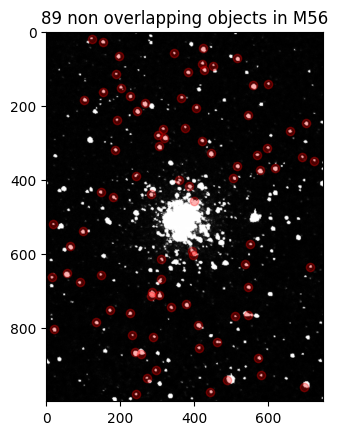

In [44]:
#Plotting image of M56 with filtered set of identified stars in red
plt.imshow(M56,cmap='gray')
plt.plot(newx,newy,marker='o',linestyle='None',alpha=.3,c='red',label='identified object')
plt.title('89 non overlapping objects in M56')
plt.xlabel('X mirrors')
plt.ylabel('Y mirrors')
plt.show()

In [ ]:
#calculating central entrance angle using Bragg's law
α_0=np.arcsin((G*λ_c)/2)

#calculating entrance angle for slit n mirror from DMD center
def entrance(n):
    α_n=np.arcsin((G*λ_c)/2)+np.arctan((n*p_M)/f_col)
    return(α_n)

#calculating exit angle for slit n mirrors from DMD center
def exit(n,λ):
    β_n=np.arcsin(G*λ-np.sin(entrance(n)))
    return(β_n)

#calculating distance between grating and camera lens 
dist=((p_D*((NM_X/2)-1))/(np.tan((exit(0,λ_c)-exit(((NM_X/2)-1),λ_c)))))
    #In retrospect, dist=f_cam

In [50]:
def spectra_pix_range(n):
    """Returns the minimum and maximum pixel values in the spectral direction spanned by the
    spectrum from a slit n mirror from the DMD center
    """
    #calculating min and max exit angle deviations from center exit angle
    minang=(exit(0,λ_c)-exit(n,λ_min)); maxang=(exit(0,λ_c)-exit(n,λ_max))
    
    #calculating min and max distances from center of detector
    lenmin=dist*(np.tan(minang)); lenmax=dist*(np.tan(maxang))
    
    #converting distance to pixel values
    pixmax=int(((ND_X/2)+(lenmin/p_D))-1) #subtracting 1 at the end accounts for the 0 index
    pixmin=int(((ND_X/2)+(lenmax/p_D)))
    
    #accounting for cutoff at the edges
    if pixmax>1999:
        pixmax=1999
    if pixmin<0:
        pixmin=0
        
    return(pixmin,pixmax)

In [ ]:
#Reading in image of M56 projected onto detector
im = img.imread('detM56.png')
im=im[:,:,0]

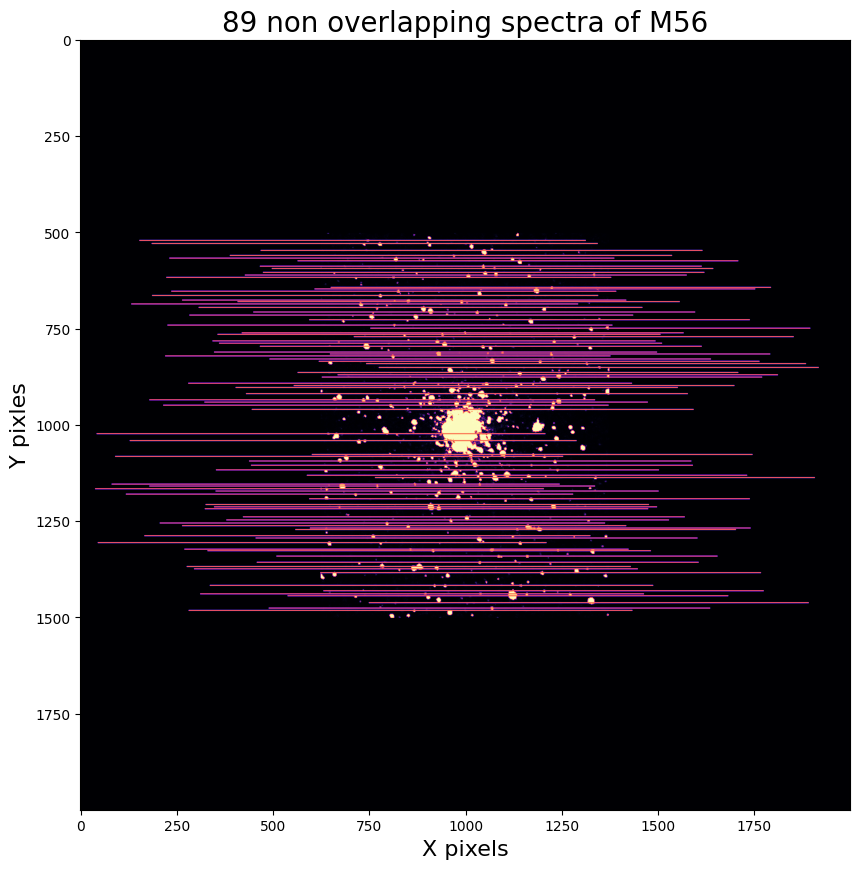

In [53]:
#Plotting location of spectra from set of identified stars onto detector
for i in range(0,len(newx)):
    Min=spectra_pix_range(int(newx[i]-(NM_X/2)))[0]
    Max=spectra_pix_range(int(newx[i]-(NM_X/2)))[1]
   
    for x in range(Min,Max):
        for y in range(int(newy[i]+(ND_Y/4)),int(newy[i]+((ND_Y/4)+3))):
            im[y][x]=.7      


plt.figure(figsize=(10,10))
plt.imshow(im,cmap='magma')

plt.xlabel('X pixels',fontsize=16)
plt.ylabel('Y pixles',fontsize=16)
plt.title('89 non overlapping spectra of M56',fontsize=20)

plt.show()